In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import sys
import os
import struct
import time
import numpy as np
import h5py
from scipy.stats import pearsonr
from itertools import chain
from scipy.io import loadmat
from tqdm import tqdm
import pickle
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fpX = np.float32
import src.numpy_utility as pnu
from src.plots import display_candidate_loss
from src.file_utility import save_stuff, flatten_dict, embed_dict
from src.torch_fwrf import get_value, get_predictions

In [3]:
import torch
import torch.nn as nn

print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device("cuda:0") #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)

#device: 3
device#: 0
device name: TITAN RTX

torch: 1.3.0
cuda:  10.1.243
cudnn: 7603
dtype: torch.float32


In [6]:
input_dir  = '/home/styvesg/repo.data/results/nsd/torch_fwrf_full_brain/' 
file_timestamp_dir = {# the classic dnn-fwrf folders
    1: "Mar-27-2020_0301",
    2: "Apr-01-2020_0250",
    3: "Apr-25-2020_1550",
    4: "May-08-2020_2148",    
    5: "Mar-29-2020_2349",
    6: "Mar-31-2020_0220",
    7: "May-17-2020_1856",
    8: "May-18-2020_2148"
}

subject = 1

saveext = ".png"
savearg = {'format':'png', 'dpi': 120, 'facecolor': 'None'}

root_dir   = os.getcwd() + '/'
net_dir    = root_dir + "net/" 
input_dir  = '/home/styvesg/repo.data/results/nsd/torch_fwrf_full_brain/' 
output_dir = root_dir+"output/S%02d/dnn_fwrf_%s/" % (subject, file_timestamp_dir[subject]) 
video_dir = root_dir+"video/"

if not os.path.exists(video_dir):
    os.makedirs(video_dir)
if not os.path.exists(net_dir):
    os.makedirs(net_dir)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Reload model file

In [12]:
model_params_set = h5py.File(input_dir + 'S%02d/dnn_fwrf_%s/model_params.h5py' % (subject, file_timestamp_dir[subject]), 'r')
model_params = embed_dict({k: np.copy(d) for k,d in model_params_set.items()})
print (model_params.keys())
model_params_set.close()

dict_keys(['aperture', 'best_lambdas', 'brain_nii_shape', 'fmask', 'image_order', 'lambdas', 'lmask', 'params', 'shared_mask', 'trn_size', 'tuning_masks', 'val_cc', 'val_size', 'voxel_index', 'voxel_mask', 'voxel_roi'])


# Load stimuli

In [13]:
nsd_root = "/home/styvesg/repo.data/datasets/nsd/"
stim_root = nsd_root + "nsddata_stimuli/stimuli/nsd/"
beta_root = nsd_root + "nsddata_betas/ppdata/"
mask_root = nsd_root + "nsddata/ppdata/"

exp_design_file = nsd_root + "nsddata/experiments/nsd/nsd_expdesign.mat"
stim_file       = stim_root + "nsd_stimuli.hdf5"

In [14]:
exp_design = loadmat(exp_design_file)
ordering = exp_design['masterordering'].flatten() - 1 # zero-indexed ordering of indices (matlab-like to python-like)

image_data_set = h5py.File(stim_root + "S%d_stimuli_227.h5py"%subject, 'r')
image_data = np.copy(image_data_set['stimuli']).astype(np.float32) / 255.
image_data_set.close()

print (image_data.shape)
print (image_data.dtype)
print (np.min(image_data[0]), np.max(image_data[0]))

(10000, 3, 227, 227)
float32
0.0 1.0


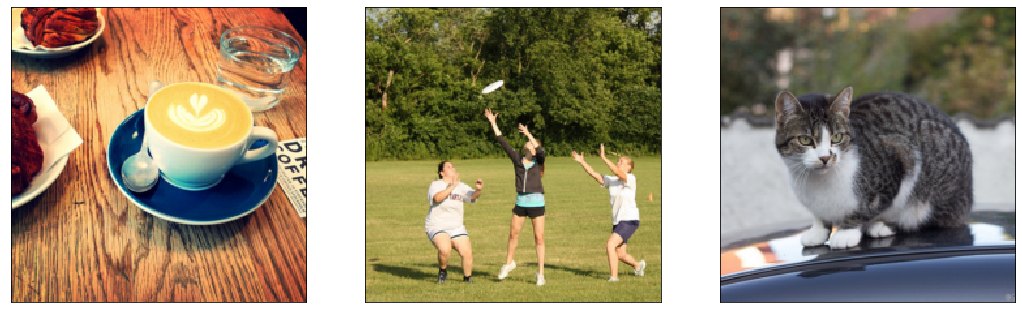

In [15]:
plt.figure(figsize=(18,6))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(image_data[6+i].transpose((1,2,0)), cmap='gray', interpolation='None')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)

# Load Voxels

In [16]:
from src.file_utility import load_mask_from_nii, view_data

brain_nii_shape = model_params['brain_nii_shape']
voxel_mask = model_params['voxel_mask']
voxel_idx = model_params['voxel_index']
voxel_roi = model_params['voxel_roi']

# Noise ceiling

In [20]:
ncsnr_full = load_mask_from_nii(beta_root + "subj%02d/func1pt8mm/betas_fithrf_GLMdenoise_RR/ncsnr.nii.gz"%subject)
voxel_ncsnr = ncsnr_full.flatten()[voxel_mask]

nc = np.sqrt(voxel_ncsnr**2/(voxel_ncsnr**2+1)) 
volume_nc  = view_data(brain_nii_shape, voxel_idx, nc, save_to=input_dir + 'S%02d/dnn_fwrf_%s/nc'%(subject, file_timestamp_dir[subject]))

In [21]:
volume_val_cc_nc_ratio  = view_data(brain_nii_shape, voxel_idx, model_params['val_cc'] / nc, save_to=input_dir + 'S%02d/dnn_fwrf_%s/val_cc_nc_ratio'%(subject, file_timestamp_dir[subject]))

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


## Display a slice of the data

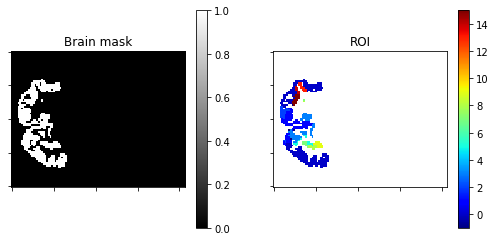

In [11]:
volume_brain_mask = view_data(brain_nii_shape, np.arange(len(voxel_mask)), voxel_mask)
volume_brain_roi  = view_data(brain_nii_shape, voxel_idx, voxel_roi)

slice_idx = 40
fig = plt.figure(figsize=(18,4))
plt.subplot(1,4,1)
plt.imshow(volume_brain_mask[:,:,slice_idx], cmap='gray', interpolation='None')
plt.title('Brain mask')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])
plt.subplot(1,4,2)
plt.imshow(volume_brain_roi[:,:,slice_idx], cmap='jet', interpolation='None')
plt.title('ROI')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])

In [12]:
beta_subj = beta_root + "subj%02d/func1pt8mm/betas_fithrf_GLMdenoise_RR/" % (subject,)

from src.load_nsd import load_betas
voxel_data, filenames = load_betas(folder_name=beta_subj, zscore=True, voxel_mask=voxel_mask, up_to=-1)
print (voxel_data.shape)

/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session01.mat
int16 -32768 32767 (750, 83, 104, 81)
<beta> = 1.066, <sigma> = 0.915
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session02.mat
int16 -32768 32767 (750, 83, 104, 81)
<beta> = 0.927, <sigma> = 0.826
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session03.mat
int16 -32768 32767 (750, 83, 104, 81)
<beta> = 1.163, <sigma> = 0.944
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session04.mat
int16 -32768 32767 (750, 83, 104, 81)
<beta> = 0.886, <sigma> = 0.797
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session05.mat
int16 -32768 32767 (750, 83, 104, 81)
<beta> = 1.007, <sigma> = 0.892
/home/styvesg/repo.data/datasets/ns

## Voxel grouping and voxel ROI iterator

In [13]:
from src.roi import iterate_roi, roi_map

roi_group_names = ['V1', 'V2', 'V3', 'V4', 'VO', 'PHC', 'MST', 'hMT', 'LO', 'V3a/b', 'IPS', 'All']
roi_group = [[1,2],[3,4],[5,6], [7], [8,9], [10,11], [12], [13], [14,15], [16,17], [18,19,20,21,22,23], np.arange(0,24)]
for roi_mask, roi_name in iterate_roi(roi_group, voxel_roi, roi_map, group_name=roi_group_names):
    print ("%d \t: %s" % (np.sum(roi_mask), roi_name))

1982 	: V1
1565 	: V2
1385 	: V3
462 	: V4
519 	: VO
374 	: PHC
54 	: MST
281 	: hMT
517 	: LO
875 	: V3a/b
931 	: IPS
15608 	: All


## Reduce the stimulus set to those of which we have responses so far.
- It just so happens that images with index less than 1000 are shared among subjects and are garanteed not to be shown in the remainder. We therefore chose to reparate our training and validation set along these lines.
- We could have reduced the number of voxels already but I needed them for something else at another point.

In [14]:
data_size, nv = voxel_data.shape 
print ("Total number of voxels = %d" % nv)
ordering_data = ordering[:data_size]

shared_mask = model_params['shared_mask']
trn_size = model_params['trn_size']
val_size = model_params['val_size']

Total number of voxels = 15660


In [15]:
## double and triple check that I haven't misaligned the image and responses.
#trn_voxel_data = voxel_data[~shared_mask]
val_voxel_data = voxel_data[shared_mask]
val_image_data = image_data[:1000]
#stim_data = image_data[ordering_data]  # reduce to only the samples available thus far
#trn_stim_data = stim_data[~shared_mask]
#val_stim_data = stim_data[shared_mask]

In [16]:
#del stim_data
#del voxel_data

# fwRF training procedure
The model is
$$ r(t) = b + W * [f(\int_\mathrm{space}\phi(x,y,t) * g(x,y) dxdy) - m] / \sigma $$
where
$g(x,y)$ is a gaussian pooling field shared by all feature maps

$\phi(x,y,t)$ are the feature maps corresponding to stimuli $t$

$W, b$ are the feature weights and bias of the linearized model for each voxels

$f(\cdot)$ is an optional nonlinearity

$m,\sigma$ are normalization coefficient to facilitate regularization

## Rebuild model
Prediction will take a considerable amount of time.

In [20]:
from imp import reload
import src.torch_fwrf as aaa
reload(aaa)
from src.torch_fwrf import get_predictions

In [21]:
from torchvision.models.alexnet import Alexnet_fmaps
from src.torch_feature_space import Torch_filter_fmaps
from src.torch_fwrf import Torch_fwRF_voxel_block

voxel_batch_size = 500 # 200
#_log_act_func = lambda _x: torch.log(1 + torch.abs(_x))*torch.tanh(torch.abs(_x))

_fmaps_fn = Alexnet_fmaps().to(device)
_fmaps_fn = Torch_filter_fmaps(_fmaps_fn, model_params['lmask'], model_params['fmask'])
_fwrf_fn  = Torch_fwRF_voxel_block(_fmaps_fn, [p[:voxel_batch_size] if p is not None else None for p in model_params['params']], \
                                   _nonlinearity=None, input_shape=image_data.shape, aperture=1.0)

In [22]:
sample_batch_size = 200 # 1000

voxel_pred = get_predictions(val_image_data, _fmaps_fn, _fwrf_fn, model_params['params'], sample_batch_size=sample_batch_size)

samples [ 2800:2999 ] of 3000, voxels [ 15500:15659 ] of 15660
---------------------------------------
total time = 487.583364s
sample throughput = 0.162528s/sample
voxel throughput = 0.031136s/voxel


## Validation accuracy

In [ ]:
val_voxel_pred = voxel_pred[ordering[shared_mask]]

In [23]:
val_cc  = np.zeros(shape=(nv), dtype=fpX)
for v in tqdm(range(nv)):    
    val_cc[v] = np.corrcoef(val_voxel_data[:,v], val_voxel_pred[:,v])[0,1]  
val_cc = np.nan_to_num(val_cc)

100%|██████████| 15660/15660 [00:02<00:00, 5442.64it/s]


## Compare validation accuracy to file record

/home/styvesg/Documents/PostDoc/GitRepo/nsd/src/plots.py:109: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax1=g.ax_marg_x.hist(x[np.logical_and(mask, x<0)],log=True, color=color1, bins=50, range=xlim) #distplot(color=".5",kde=False) #hist_kws={'log':True}


<Figure size 576x576 with 0 Axes>

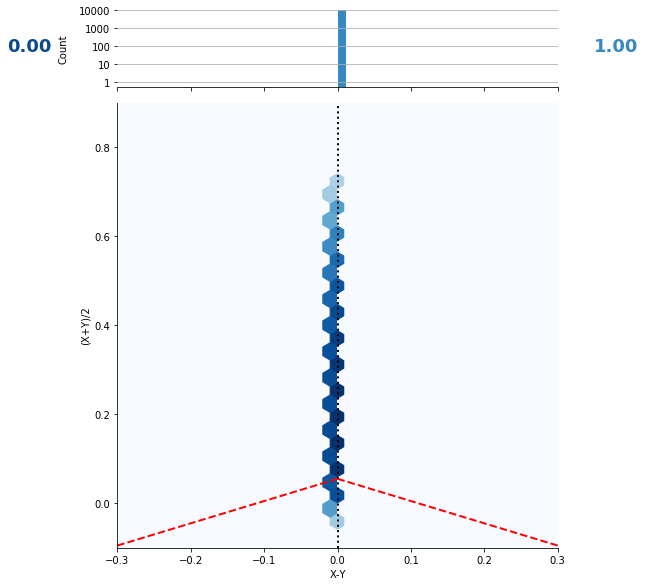

In [24]:
from src.plots import plot_fwrf_paper_compare

fig=plt.figure(figsize=(8, 8))
_=plot_fwrf_paper_compare(model_params['val_cc'], val_cc, 0.055, [-.3, .3], [-.1, .9])

# Do more interesting stuff... e.g. pixel-space gradient

In [33]:
_x = torch.tensor(image_data[:sample_batch_size]).to(device).requires_grad_() # the input variable.

best_voxels = np.argsort(val_cc)[::-1]
_fwrf_fn.load_voxel_block(*[p[best_voxels[:voxel_batch_size]] if p is not None else None for p in model_params['params']])
_voxel_pred = _fwrf_fn(_fmaps_fn(_x))

_voxel_data = torch.tensor(val_voxel_data[:sample_batch_size, :voxel_batch_size]).to(device).requires_grad_(False)
_l = torch.sum((_voxel_data - _voxel_pred)**2)
_l.backward()

print (_voxel_pred)
print (_x.grad.size())

tensor([[ 0.5351,  0.7386, -0.4717,  ...,  0.4756,  0.0794,  0.3118],
        [ 0.4421,  0.6338,  0.3790,  ...,  0.9139, -0.1069,  1.1683],
        [ 0.7847,  0.7814, -0.4989,  ..., -0.5146,  0.4880, -0.0565],
        ...,
        [-0.5407, -0.5153,  0.4129,  ...,  0.1438, -0.4966,  0.1448],
        [ 0.1048,  0.0633,  0.1481,  ...,  0.6374, -0.0993,  0.0353],
        [-0.4618, -0.6255, -0.5656,  ..., -0.2068, -0.2387, -0.2062]],
       device='cuda:0', grad_fn=<AsStridedBackward>)
torch.Size([200, 3, 227, 227])


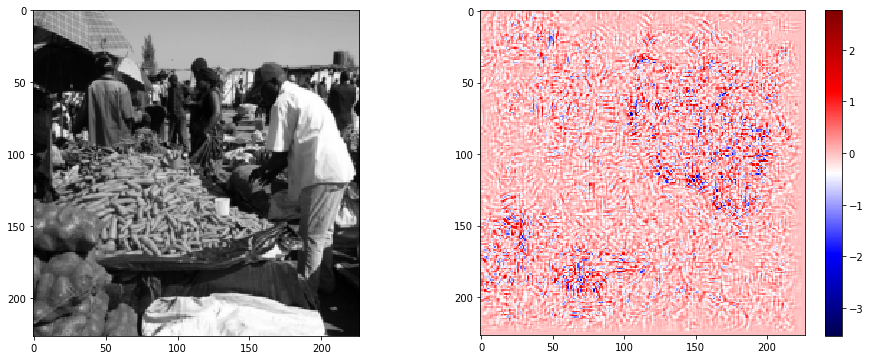

In [34]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.imshow(np.mean(get_value(_x.data)[0], axis=0), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(np.mean(get_value(_x.grad)[0], axis=0), cmap='seismic')
plt.colorbar()